In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

def invboxcox(y, lamda):
    if lamda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(y*lamda+1)/lamda)

In [138]:
wage = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
wage

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


# Визуальный анализ ряда #

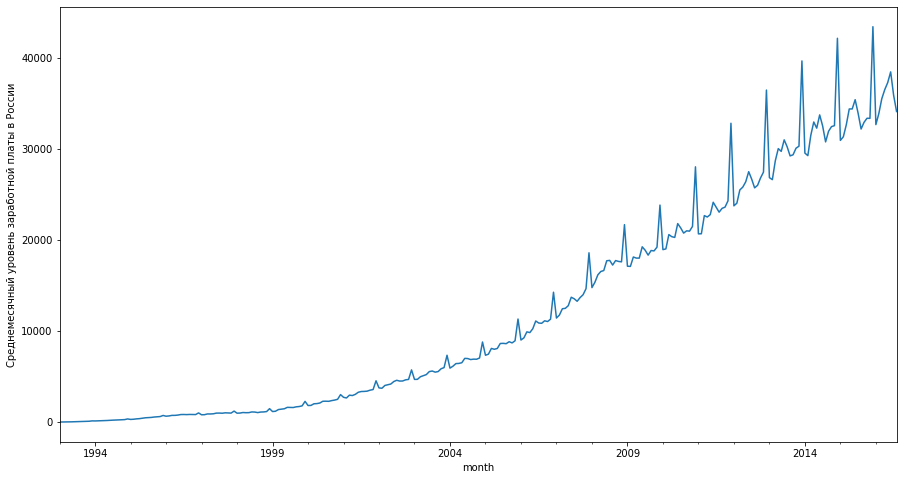

In [116]:
plt.figure(figsize=(15, 8))
wage.WAG_C_M.plot()
plt.ylabel('Cреднемесячный уровень заработной платы в России')
plt.show()

Резюме: ряд имеет явно выраженный тренд и сезонную компоненту в 12 месяцев; заметна дисперсия ряда. Похоже, что есть смысл оставить данные по зарплатам, начиная с 2009 года

In [155]:
months = (2009-1993)*12
wage = wage.iloc[months:]
wage

,WAG_C_M
month,
2009-01-01,17119.0
2009-02-01,17098.0
2009-03-01,18129.0
2009-04-01,18009.0
2009-05-01,18007.0
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


**Проверка стационарности и STL-декомпозиция ряда:**

<Figure size 1080x720 with 0 Axes>

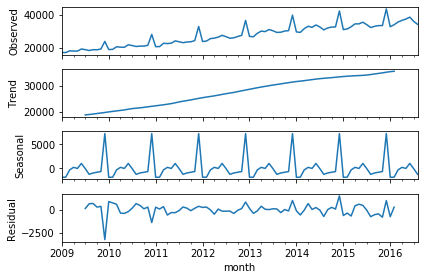

Критерий Дики-Фуллера: 0.5943516758875615


In [156]:
plt.figure(figsize=(15, 10))
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()
plt.show()
print('Критерий Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(wage.WAG_C_M)[1]))

Cреднемесячный уровень заработной платы в России имеет тренд монотонно увеличивается, сезоность 12 месяцев, и остатка имеет циклически

По критерии Дики-Фуллера ряд не стационарный.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

C:\Users\roy_d\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Оптимальный параметр преобразования Бокса-Кокса: 0.43331671155659096
Критерий Дики-Фуллера: p= 0.19396951787267452


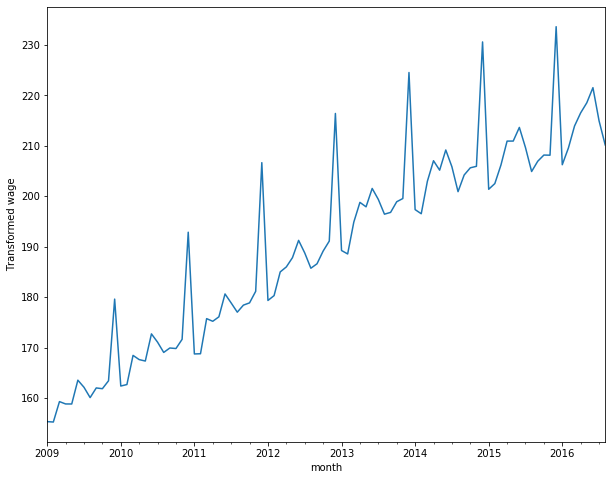

In [157]:
wage['WAG_boxcox'], lamda = stats.boxcox(wage.WAG_C_M)
plt.figure(figsize=(10,8))
wage.WAG_boxcox.plot()
plt.ylabel('Transformed wage')
print('Оптимальный параметр преобразования Бокса-Кокса: {}'.format(lamda))
print('Критерий Дики-Фуллера: p= {}'.format(sm.tsa.stattools.adfuller(wage.WAG_boxcox)[1]))

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности (p > 0.05). Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

C:\Users\roy_d\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<Figure size 1080x720 with 0 Axes>

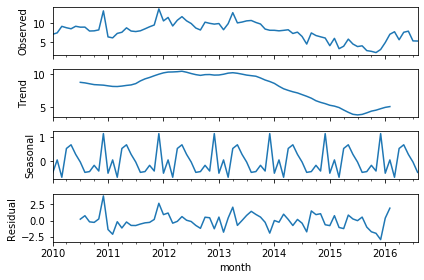

Критерий Дики-Фуллера: p= 0.4745982629409762


In [158]:
wage['WAG_boxcox_diff'] = wage.WAG_boxcox - wage.WAG_boxcox.shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(wage.WAG_boxcox_diff.dropna()).plot()
plt.show()
print('Критерий Дики-Фуллера: p= {}'.format(sm.tsa.stattools.adfuller(wage.WAG_boxcox_diff.dropna())[1]))

По критерии Дики-Фуллера отвергает гипотезу нестационарности, но сезонное дифференцирование не удалось полностью избавиться от тренда. Попробуем добавить ещё обычное дифференцирование:

C:\Users\roy_d\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<Figure size 1080x720 with 0 Axes>

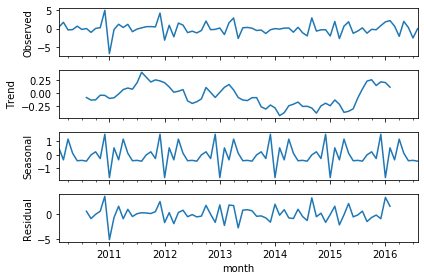

Критерий Дики-Фуллера: p= 7.075979674143955e-15


In [159]:
plt.figure(figsize=(15,10))
wage['WAG_box_diff2'] = wage.WAG_boxcox_diff - wage.WAG_boxcox_diff.shift(1)
sm.tsa.seasonal_decompose(wage.WAG_box_diff2.dropna()).plot()
plt.show()
print('Критерий Дики-Фуллера: p= {}'.format(sm.tsa.stattools.adfuller(wage.WAG_box_diff2.dropna())[1]))

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

### Выбор начальных приближений для p, q, P, Q

Посмотрим на ACF и PACF полученного ряда:

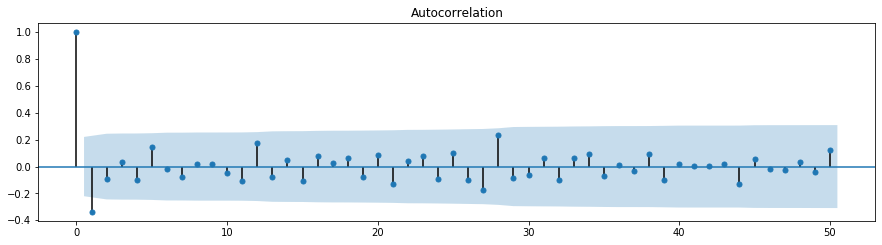

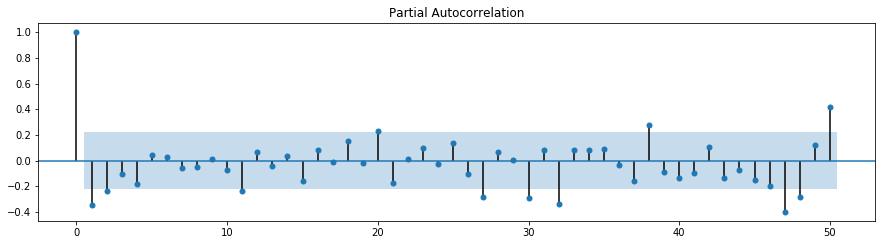

In [160]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.WAG_box_diff2.dropna().values.squeeze(), lags=50, ax=ax)
plt.show()
plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.WAG_box_diff2.dropna().values.squeeze(), lags=50, ax=ax)
plt.show()

Начальные приближения: Q= 0, q= 1, P= 4, p= 11

In [167]:
Q = 0
qs = range(0,2)
Ps = range(0,5)
ps = range(0,12)
D = 1
d = 1

In [168]:
parameters = list(product(ps, qs, Ps))
len(parameters)

120

In [169]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters:
    try:
        model = sm.tsa.statespace.SARIMAX(wage.WAG_boxcox, order=(param[0], d, param[1]),
                                         seasonal_order=(param[2], D, Q, 12)).fit(disp=-1)
    except ValueError:
        print('Wrong parameters: ', param)
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    
    results.append([best_param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 2min 27s


In [170]:
results_table = pd.DataFrame(results)
results_table.columns = ['Parameters', 'aic']
print(results_table.sort_values(by='aic', ascending=True).head())

   Parameters         aic
6   (0, 1, 1)  292.240707
5   (0, 1, 0)  292.539667
16  (0, 1, 1)  293.441471
15  (0, 1, 1)  293.751158
7   (0, 1, 1)  293.764515


In [171]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         WAG_boxcox   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -143.120
Date:                            Wed, 20 May 2020   AIC                            292.241
Time:                                    18:11:12   BIC                            299.349
Sample:                                01-01-2009   HQIC                           295.089
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4867      0.074     -6.611      0.000      -0.631      -0.342
ar.S.L12       0.2097      0.105   

Её остатки:

Критерий Стьюдента: p= 0.6506875249318205
Критерий Дики-Фуллера: p= 6.909885397614038e-22


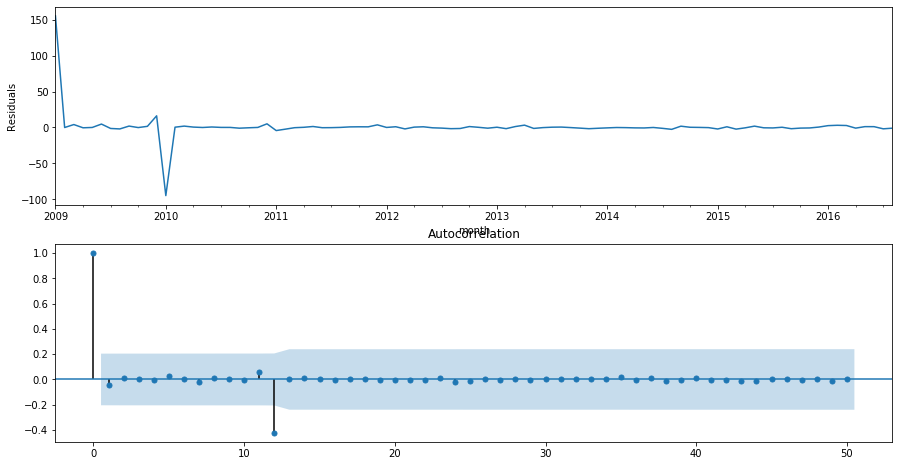

In [172]:
plt.figure(figsize=(15, 8))
plt.subplot(211)
best_model.resid.dropna().plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.dropna().values.squeeze(), lags=50, ax=ax)
print("Критерий Стьюдента: p= {}".format(stats.ttest_1samp(best_model.resid.dropna(), 0)[1]))
print("Критерий Дики-Фуллера: p= {}".format(sm.tsa.stattools.adfuller(best_model.resid.dropna())[1]))

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

C:\Users\roy_d\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


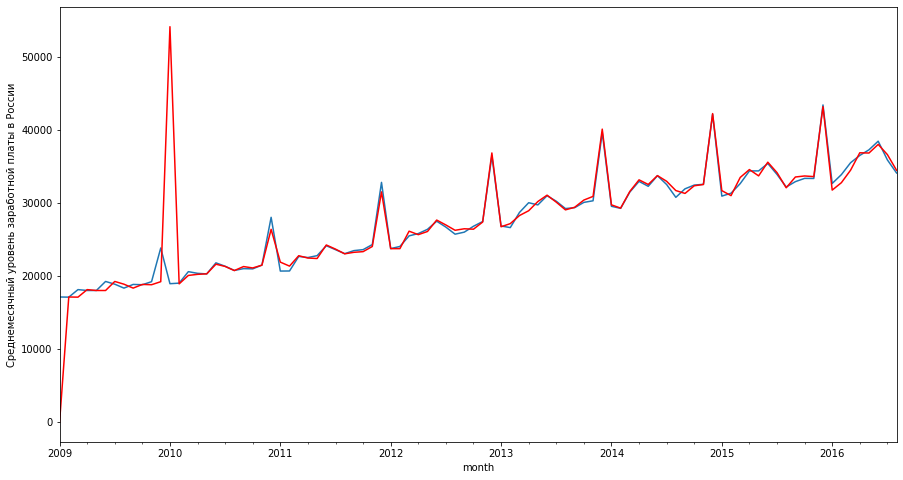

In [173]:
wage['model'] = invboxcox(best_model.fittedvalues, lamda)
plt.figure(figsize=(15, 8))
wage.WAG_C_M.plot()
wage.model.dropna().plot(color='r')
plt.ylabel('Cреднемесячный уровень заработной платы в России')
plt.show()

## Прогноз

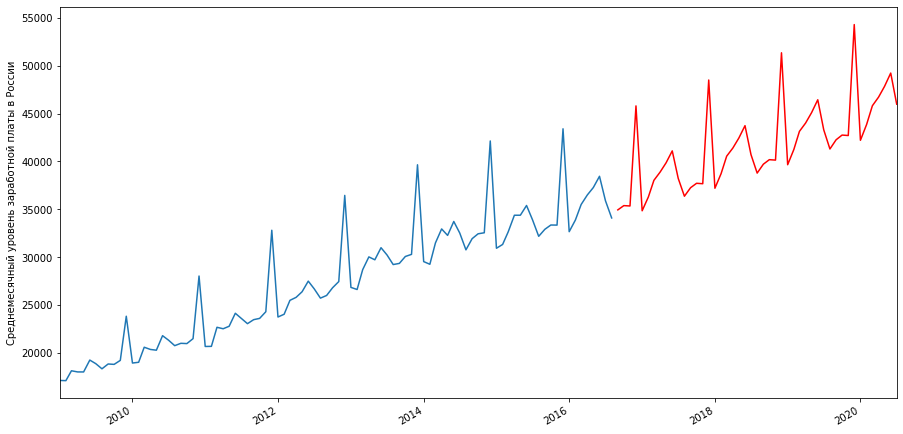

In [175]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 48)]
future = pd.DataFrame(index=date_list, columns=wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=92, end=139), lamda)

plt.figure(figsize=(15, 8))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Cреднемесячный уровень заработной платы в России')
plt.show()

In [176]:
real_wage = pd.read_csv('WAG_2016-2020.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
real_wage

,WAG_C_M
month,
2016-09-01,35843
2016-10-01,35749
2016-11-01,36195
2016-12-01,47554
2017-01-01,34422
2017-02-01,35497
2017-03-01,37899
2017-04-01,39225
2017-05-01,39679


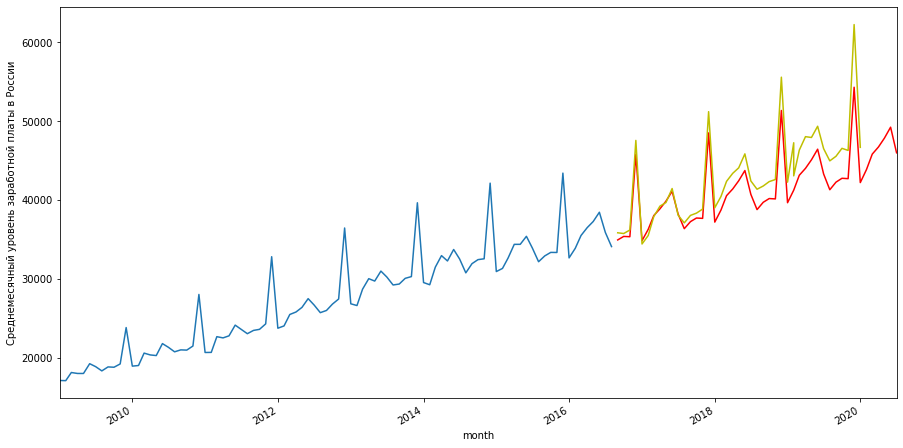

In [177]:
plt.figure(figsize=(15, 8))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
real_wage.WAG_C_M.plot(color='y')
plt.ylabel('Cреднемесячный уровень заработной платы в России')
plt.show()